# New section Preparing Our Workspace

We start by mounting our google drive:

In [ ]:
!git add .

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


and installing the NetCDF package to help interpret different data structures:

In [9]:
pip install netCDF4

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 66.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 54.0 MB/s eta 0:00:00


# Classifying Altimetry Data

In this notebook, we are going to be using unsupervised learning methods to classify sea ice and leads in the Sentinel-3 Altimetry dataset. In particular, we are using the Gaussian Mixture Model (GMM) method. This model uses the Expectation-Maximisation algorithm for fitting data. It works by calculating the probability that a data point belongs to a cluster, and then updating the parameters of the components (gaussians) to maximize the liklihood of the classification. GMM gives more uncertanties in the data classification, and is flexible in the shapes it can adapt to.

Below is a basic example of GMM applied to random data:

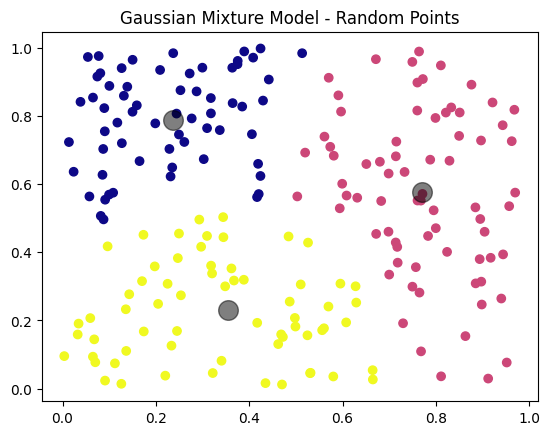

In [10]:
# Importing packages (model is made using SciKit Learn)
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
import numpy as np

# Sample data
X = np.random.rand(200, 2)

# GMM model
gmm = GaussianMixture(n_components=3)
gmm.fit(X)
y_gmm = gmm.predict(X)

# Plotting
plt.scatter(X[:, 0], X[:, 1], c=y_gmm, cmap='plasma')
centers = gmm.means_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)
plt.title('Gaussian Mixture Model - Random Points')
plt.show()

Now let's apply it to altimetry data from the Sentinel-3 satelite to distinguish between sea ice and leads. The code below begins by defining two functions. The peakiness function is used to determine how 'peaky' the signal from the altimeter is. Leads provide a peakier signal than sea ice because of their higher reflectivity. The calculate_SSD function gives us the standard deviation of each of the sea ice and lead altimetry data.

In [11]:
from netCDF4 import Dataset
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import numpy.ma as ma
import glob
from matplotlib.patches import Polygon
import scipy.spatial as spatial
from scipy.spatial import KDTree
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.mixture import GaussianMixture
from scipy.cluster.hierarchy import linkage, fcluster

#=========================================================================================================
#===================================  SUBFUNCTIONS  ======================================================
#=========================================================================================================

#*args and **kwargs allow you to pass an unspecified number of arguments to a function,
#so when writing the function definition, you do not need to know how many arguments will be passed to your function
#**kwargs allows you to pass keyworded variable length of arguments to a function.
#You should use **kwargs if you want to handle named arguments in a function.
#double star allows us to pass through keyword arguments (and any number of them).
def peakiness(waves, **kwargs):

    "finds peakiness of waveforms."

    #print("Beginning peakiness")
    # Kwargs are:
    #          wf_plots. specify a number n: wf_plots=n, to show the first n waveform plots. \

    import numpy as np
    import matplotlib
    import matplotlib.pyplot as plt
    import time

    print("Running peakiness function...")

    size=np.shape(waves)[0] #.shape property is a tuple of length .ndim containing the length of each dimensions
                            #Tuple of array dimensions.

    waves1=np.copy(waves)

    if waves1.ndim == 1: #number of array dimensions
        print('only one waveform in file')
        waves2=waves1.reshape(1,np.size(waves1)) #numpy.reshape(a, newshape, order='C'), a=array to be reshaped
        waves1=waves2

    # *args is used to send a non-keyworded variable length argument list to the function
    def by_row(waves, *args):
        "calculate peakiness for each waveform"
        maximum=np.nanmax(waves)
        if maximum > 0:

            maximum_bin=np.where(waves==maximum)
            #print(maximum_bin)
            maximum_bin=maximum_bin[0][0]
            waves_128=waves[maximum_bin-50:maximum_bin+78]

            waves=waves_128

            noise_floor=np.nanmean(waves[10:20])
            where_above_nf=np.where(waves > noise_floor)

            if np.shape(where_above_nf)[1] > 0:
                maximum=np.nanmax(waves[where_above_nf])
                total=np.sum(waves[where_above_nf])
                mean=np.nanmean(waves[where_above_nf])
                peaky=maximum/mean

            else:
                peaky = np.nan
                maximum = np.nan
                total = np.nan

        else:
            peaky = np.nan
            maximum = np.nan
            total = np.nan

        if 'maxs' in args:
            return maximum
        if 'totals' in args:
            return total
        if 'peaky' in args:
            return peaky

    peaky=np.apply_along_axis(by_row, 1, waves1, 'peaky') #numpy.apply_along_axis(func1d, axis, arr, *args, **kwargs)

    if 'wf_plots' in kwargs:
        maximums=np.apply_along_axis(by_row, 1, waves1, 'maxs')
        totals=np.apply_along_axis(by_row, 1, waves1, 'totals')

        for i in range(0,kwargs['wf_plots']):
            if i == 0:
                print("Plotting first "+str(kwargs['wf_plots'])+" waveforms")

            plt.plot(waves1[i,:])#, a, col[i],label=label[i])
            plt.axhline(maximums[i], color='green')
            plt.axvline(10, color='r')
            plt.axvline(19, color='r')
            plt.xlabel('Bin (of 256)')
            plt.ylabel('Power')
            plt.text(5,maximums[i],"maximum="+str(maximums[i]))
            plt.text(5,maximums[i]-2500,"total="+str(totals[i]))
            plt.text(5,maximums[i]-5000,"peakiness="+str(peaky[i]))
            plt.title('waveform '+str(i)+' of '+str(size)+'\n. Noise floor average taken between red lines.')
            plt.show()


    return peaky

#=========================================================================================================
#=========================================================================================================
#=========================================================================================================


def unpack_gpod(variable):

    from scipy.interpolate import interp1d

    time_1hz=SAR_data.variables['time_01'][:]
    time_20hz=SAR_data.variables['time_20_ku'][:]
    time_20hzC = SAR_data.variables['time_20_c'][:]

    out=(SAR_data.variables[variable][:]).astype(float)  # convert from integer array to float.

    #if ma.is_masked(dataset.variables[variable][:]) == True:
    #print(variable,'is masked. Removing mask and replacing masked values with nan')
    out=np.ma.filled(out, np.nan)

    if len(out)==len(time_1hz):

        print(variable,'is 1hz. Expanding to 20hz...')
        out = interp1d(time_1hz,out,fill_value="extrapolate")(time_20hz)

    if len(out)==len(time_20hzC):
        print(variable, 'is c band, expanding to 20hz ku band dimension')
        out = interp1d(time_20hzC,out,fill_value="extrapolate")(time_20hz)
    return out


#=========================================================================================================
#=========================================================================================================
#=========================================================================================================

def calculate_SSD(RIP):

    from scipy.optimize import curve_fit
    # from scipy import asarray as ar,exp
    from numpy import asarray as ar, exp

    do_plot='Off'

    def gaussian(x,a,x0,sigma):
            return a * np.exp(-(x - x0)**2 / (2 * sigma**2))

    SSD=np.zeros(np.shape(RIP)[0])*np.nan
    x=np.arange(np.shape(RIP)[1])

    for i in range(np.shape(RIP)[0]):

        y=np.copy(RIP[i])
        y[(np.isnan(y)==True)]=0

        if 'popt' in locals():
            del(popt,pcov)

        SSD_calc=0.5*(np.sum(y**2)*np.sum(y**2)/np.sum(y**4))
        #print('SSD calculated from equation',SSD)

        #n = len(x)
        mean_est = sum(x * y) / sum(y)
        sigma_est = np.sqrt(sum(y * (x - mean_est)**2) / sum(y))
        #print('est. mean',mean,'est. sigma',sigma_est)

        try:
            popt,pcov = curve_fit(gaussian, x, y, p0=[max(y), mean_est, sigma_est],maxfev=10000)
        except RuntimeError as e:
            print("Gaussian SSD curve-fit error: "+str(e))
            #plt.plot(y)
            #plt.show()

        except TypeError as t:
            print("Gaussian SSD curve-fit error: "+str(t))

        if do_plot=='ON':

            plt.plot(x,y)
            plt.plot(x,gaussian(x,*popt),'ro:',label='fit')
            plt.axvline(popt[1])
            plt.axvspan(popt[1]-popt[2], popt[1]+popt[2], alpha=0.15, color='Navy')
            plt.show()

            print('popt',popt)
            print('curve fit SSD',popt[2])

        if 'popt' in locals():
            SSD[i]=abs(popt[2])


    return SSD

This next bit of code gets the data, prepares it and runs it through each of the functions described above:

In [12]:
path = '/content/drive/MyDrive/GEOL0069/Week_4/unsupervised_learning/assignment_git/'
SAR_file = 'S3A_SR_2_LAN_SI_20190307T005808_20190307T012503_20230527T225016_1614_042_131______LN3_R_NT_005.SEN3'
SAR_data = Dataset(path + SAR_file + '/enhanced_measurement.nc')

SAR_lat = unpack_gpod('lat_20_ku')
SAR_lon = unpack_gpod('lon_20_ku')
waves   = unpack_gpod('waveform_20_ku')
sig_0   = unpack_gpod('sig0_water_20_ku')
RIP     = unpack_gpod('rip_20_ku')
flag = unpack_gpod('surf_type_class_20_ku')

# Filter out bad data points using criteria (here, lat >= -99999)
find = np.where(SAR_lat >= -99999)
SAR_lat = SAR_lat[find]
SAR_lon = SAR_lon[find]
waves   = waves[find]
sig_0   = sig_0[find]
RIP     = RIP[find]

# Calculate additional features
PP = peakiness(waves)
SSD = calculate_SSD(RIP)

# Convert to numpy arrays (if not already)
sig_0_np = np.array(sig_0)
PP_np    = np.array(PP)
SSD_np   = np.array(SSD)

# Create data matrix
data = np.column_stack((sig_0_np, PP_np, SSD_np))

# Standardize the data
scaler = StandardScaler()
data_normalized = scaler.fit_transform(data)

Running peakiness function...


<ipython-input-11-48fc91f7787c>:62: RuntimeWarning: Mean of empty slice
  noise_floor=np.nanmean(waves[10:20])


Gaussian SSD curve-fit error: Optimal parameters not found: Number of calls to function has reached maxfev = 10000.
Gaussian SSD curve-fit error: Optimal parameters not found: Number of calls to function has reached maxfev = 10000.
Gaussian SSD curve-fit error: Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


As with many large datasets of natural data, there are some NaN values, which are removed using the following code. It also tells us how many NaN values there are:

In [13]:
nan_count = np.isnan(data_normalized).sum()
print(f"Number of NaN values in the array: {nan_count}")

data_cleaned = data_normalized[~np.isnan(data_normalized).any(axis=1)]

mask = ~np.isnan(data_normalized).any(axis=1)
waves_cleaned = np.array(waves)[mask]
flag_cleaned = np.array(flag)[mask]

data_cleaned = data_cleaned[(flag_cleaned==1)|(flag_cleaned==2)]
waves_cleaned = waves_cleaned[(flag_cleaned==1)|(flag_cleaned==2)]
flag_cleaned = flag_cleaned[(flag_cleaned==1)|(flag_cleaned==2)]

Number of NaN values in the array: 1283


Now our data is prepared, we can proceed with creating our GMM model:

In [14]:
gmm = GaussianMixture(n_components=2, random_state=0)
gmm.fit(data_cleaned)
clusters_gmm = gmm.predict(data_cleaned)

This code quickly tells us how many points have been classified into each of the classes.

0 - Sea Ice

1 - Leads

In [15]:
unique, counts = np.unique(clusters_gmm, return_counts=True)
class_counts = dict(zip(unique, counts))
print("Cluster counts:", class_counts)

Cluster counts: {0: 8880, 1: 3315}


So now we have the peakiness, standard deviation and classification of each waveform captured by the altimeter, we can put it in a plot. The solid line here represents the average echoshape, with the standard deviation lighter behind it.

Text(0.5, 0, 'waveform bins')

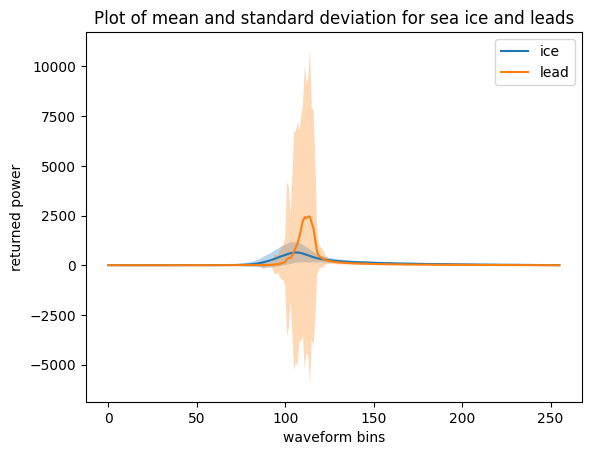

In [17]:
# mean and standard deviation for all echoes
mean_ice = np.mean(waves_cleaned[clusters_gmm==0],axis=0)
std_ice = np.std(waves_cleaned[clusters_gmm==0], axis=0)

plt.plot(mean_ice, label='ice')
plt.fill_between(range(len(mean_ice)), mean_ice - std_ice, mean_ice + std_ice, alpha=0.3)


mean_lead = np.mean(waves_cleaned[clusters_gmm==1],axis=0)
std_lead = np.std(waves_cleaned[clusters_gmm==1], axis=0)

plt.plot(mean_lead, label='lead')
plt.fill_between(range(len(mean_lead)), mean_lead - std_lead, mean_lead + std_lead, alpha=0.3)

plt.title('Plot of mean and standard deviation for sea ice and leads')
plt.legend()
plt.ylabel("returned power")
plt.xlabel("waveform bins")

Another way to represent this data is by plotting all the recorded waveforms in one graph. Below this is done for leads and sea ice:

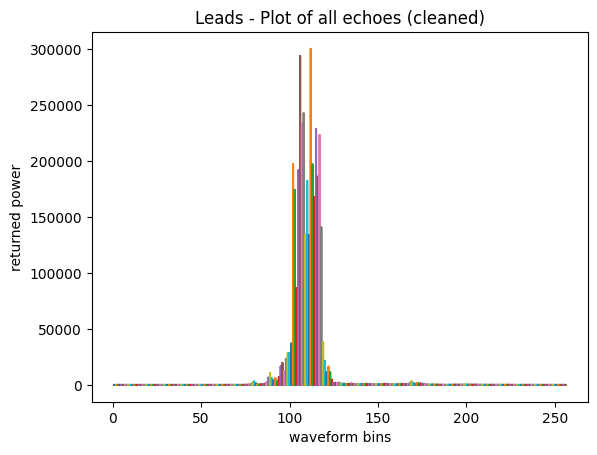

In [28]:
x = np.stack([np.arange(1,waves_cleaned[clusters_gmm==1].shape[1]+1)]*waves_cleaned[clusters_gmm==1].shape[0])
plt.plot(x,waves_cleaned[clusters_gmm==1])  # plot of all the echos
plt.title("Leads - Plot of all echoes (cleaned)")
plt.xlabel("waveform bins")
plt.ylabel("returned power")
plt.show()


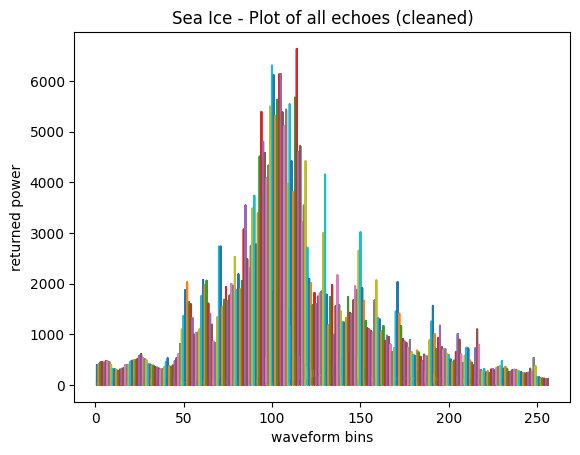

In [26]:
x = np.stack([np.arange(1,waves_cleaned[clusters_gmm==0].shape[1]+1)]*waves_cleaned[clusters_gmm==0].shape[0])
plt.plot(x,waves_cleaned[clusters_gmm==0])  # plot of all the echos
plt.title("Sea Ice - Plot of all echoes (cleaned)")
plt.xlabel("waveform bins")
plt.ylabel("returned power")
plt.show()

As expected, the waveforms classified as having come from sea ice are significantly less peaky than the waveforms classed as leads. The returned power is several orders of magnited smaller in the sea ice waveforms. Additionally, sea ice has a wider spread of waveform bins.

Another way of displaying this data is through scatter plots, as seen below. we have a combination of $\sigma^0$, pulse peakiness (pp) and standard deviation (SSD).

yellow - leads

purple - sea ice

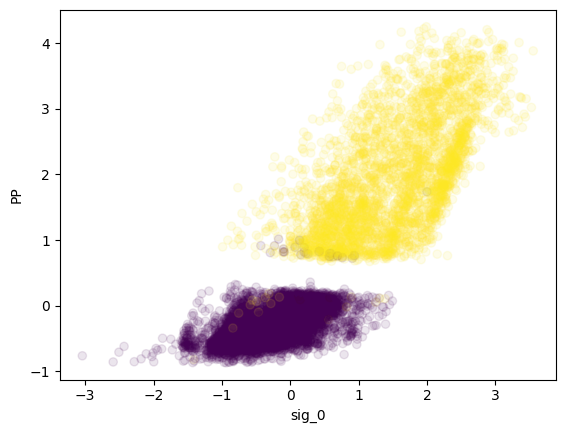

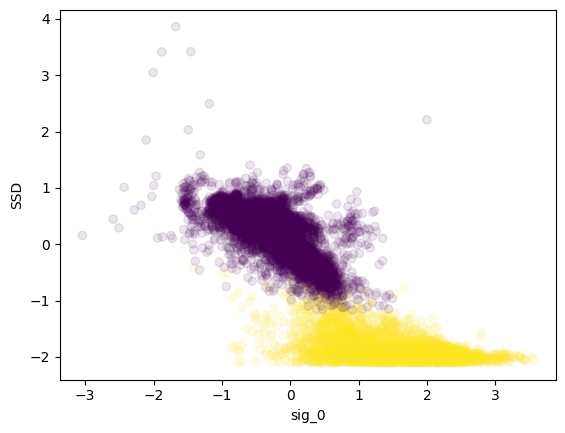

Text(0, 0.5, 'SSD')

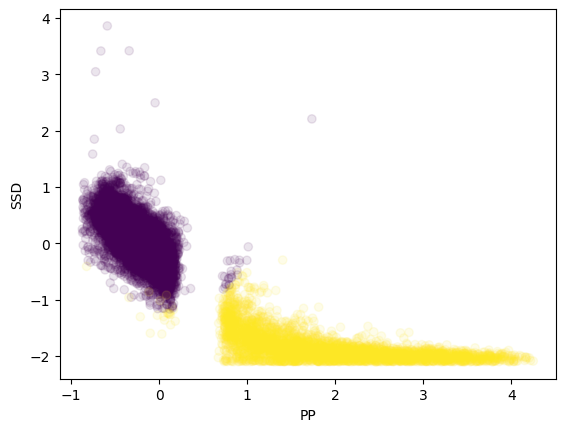

In [37]:
plt.scatter(data_cleaned[:,0],data_cleaned[:,1],c=clusters_gmm, alpha=0.1)
plt.xlabel("sig_0")
plt.ylabel("PP")
plt.show()
plt.scatter(data_cleaned[:,0],data_cleaned[:,2],c=clusters_gmm, alpha=0.1)
plt.xlabel("sig_0")
plt.ylabel("SSD")
plt.show()
plt.scatter(data_cleaned[:,1],data_cleaned[:,2],c=clusters_gmm, alpha=0.1)
plt.xlabel("PP")
plt.ylabel("SSD")

Some expected correlations are observed, such as leads having higher intensity and peakiness and lower SSD. Sea ice tends to have higher SSD but lower $\sigma^0$ and pp

# New section Comparing to ESA Dataset

To wrap up we can compare our classifications to the ESA dataset that contains sea ice and lead data. The first line of code here just converts our sea ice and lead labels to those compatible with the ESA dataset.

We produce a confusion matrix that helps us understand the error rate in our classification. The relatively low numbers of false positives and negatives confirms that our classification was succesful (though not perfectly in line with the ESA classification).


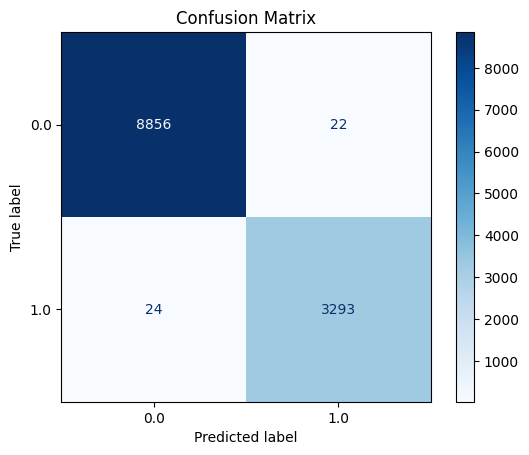


Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      8878
         1.0       0.99      0.99      0.99      3317

    accuracy                           1.00     12195
   macro avg       1.00      1.00      1.00     12195
weighted avg       1.00      1.00      1.00     12195



In [41]:
flag_cleaned_modified = flag_cleaned - 1

from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay


true_labels = flag_cleaned_modified   # true labels from the ESA dataset
predicted_gmm = clusters_gmm          # predicted labels from GMM method

# Compute confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_gmm)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=sorted(set(true_labels)))
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.show()

# Compute classification report
class_report = classification_report(true_labels, predicted_gmm)

# Print classification report
print("\nClassification Report:")
print(class_report)